<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/Project2/PorusMedia_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite volume methods for the Darcy equation

In this tutorial we present how to solve a Darcy equation with [PorePy](https://github.com/pmgbergen/porepy) by using two finite volume methods: two-point flux approximation (TPFA) and multi-point flux approximation (MPFA).

## Exercise

We consider the primal formulation of the Darcy problem: the only unknown is the pressure $p$.
We want to solve the problem on different families of grids.

Let $\Omega = [0, 1]^2$ be the domain of interest with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given
$k=I$ the matrix permeability and $f = 1$ the source term, we want to solve the following problem: find $p$ such that
$$
\nabla \cdot (- \nabla p) = f
\quad \text{in } \Omega
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial \Omega$$


We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules.

In [ ]:
!git clone https://github.com/pmgbergen/porepy.git
%cd porepy

!git checkout main

!pip install -r requirements.txt

!pip install .

In [5]:
import numpy as np
import scipy.sparse as sps

import porepy as pp

/content/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [6]:
import porepy
print(porepy.__version__)

1.8.0


We create now the grid, which could be: Cartesian or simplicial.

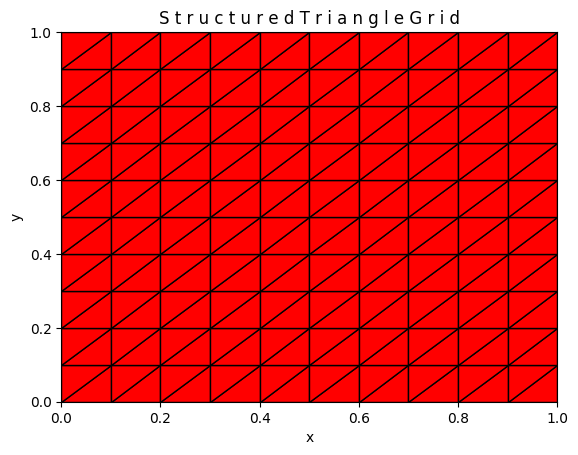

In [7]:
dim = 2
N = 10

# creation of a Cartesian grid
# sd = pp.CartGrid([N]*dim, [1]*dim)

# creation of a simplex grid
sd = pp.StructuredTriangleGrid([N] * dim, [1] * dim)

# compute the geometrical properties of the grid
sd.compute_geometry()

# represent the grid
pp.plot_grid(sd, plot_2d=True)

With the following code we set the data, in particular the permeability tensor and the scalar source.

In [16]:
key = "flow"

# Permeability
perm = pp.SecondOrderTensor(kxx=np.ones(sd.num_cells))

# Unitary scalar source already integrated in each cell
f = sd.cell_volumes

# Boundary conditions
b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]
bc = pp.BoundaryCondition(sd, b_faces, ["dir"] * b_faces.size)
bc_val = np.zeros(sd.num_faces)

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "bc": bc, "bc_values": bc_val}

data = pp.initialize_default_data(sd, {}, key, parameters)

Once the data are assigned to the grid, we need to construct the discrete problem. In particular, the linear system associated with the equation is given as
$$
A p = b
$$<br>
The right-hand side term $b$ includes the part associated with the scalar source term and with the boundary conditions, we construct first the former.

Second, we construct the matrix $A$ from the TPFA approximation and the part of the right-hand side associated to the boundary conditions. We can compute the pressure $p$ by solving the linear system.

In [17]:
# construct the lhr and rhs from the discretization of the diffusion operator
tpfa = pp.Tpfa(key)
tpfa.discretize(sd, data)
A_tpfa, b_tpfa = tpfa.assemble_matrix_rhs(sd, data)


# solve the problem
cell_p_tpfa = sps.linalg.spsolve(A_tpfa, b_tpfa + f)

Alternatively to TPFA we can use the MPFA scheme to construct the matrix $A$, and associated right-hand side, and then compute the pressure $p$.

In [18]:
# construct the lhr and rhs from the discretization of the diffusion operator
mpfa = pp.Mpfa(key)
mpfa.discretize(sd, data)
A_mpfa, b_mpfa = mpfa.assemble_matrix_rhs(sd, data)

# solve the problem
cell_p_mpfa = sps.linalg.spsolve(A_mpfa, b_mpfa + f)

We export the solutions to be visualized by [ParaView](https://www.paraview.org/).

In [19]:
save = pp.Exporter(sd, "sol", folder_name="sol")
save.write_vtu([("cell_p_tpfa", cell_p_tpfa), ("cell_p_mpfa", cell_p_mpfa)])